# Sumobot Performance Analysis Dashboard

A comprehensive analysis of bot performance metrics across matchups, timers, and actions.

## Setup and Data Loading

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

from overall_analyzer import (
    plot_action_radar,
    plot_collision_radar,
    plot_winrate_matrix,
    plot_overall_bot_metrics,
    plot_grouped_config_winrates,
    plot_time_related,
    plot_action_distribution_stacked,
    plot_timebins_intensity,
    plot_collision_timebins_intensity,
    plot_collision_distribution_stacked,
    plot_action_win_related,
    plot_all_correlations,
    plot_full_cross_heatmap_half
)

from individual_analyzer import (
    plot_individual_bot_correlations,
)

%matplotlib inline
plt.rcParams['figure.dpi'] = 100

2025-12-02 09:32:05.989 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-12-02 09:32:05.991 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-12-02 09:32:05.993 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-12-02 09:32:05.994 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-12-02 09:32:05.995 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [3]:
# Load summary data
df_sum = pd.read_csv("summary_bot.csv").rename(columns={"Duration": "Duration (ms)"})
df = pd.read_csv("summary_matchup.csv")
df_timebins = pd.read_csv("summary_action_timebins.csv")
df_collision_timebins = pd.read_csv("summary_collision_timebins.csv")

# Configuration
cfg = {
    "Timer": sorted(df["Timer"].unique().tolist()),
    "ActInterval": sorted(df["ActInterval"].unique().tolist()),
    "Round": sorted(df["Round"].unique().tolist()),
    "SkillLeft": sorted(df["SkillLeft"].unique().tolist()),
    "SkillRight": sorted(df["SkillRight"].unique().tolist()),
    "Bots": sorted(df["Bot_L"].unique().tolist()),
}
bots = str.join(", ", cfg["Bots"])

# Display settings
width = 10
height = 6

print("Data loaded successfully!")
print(f"\nBots in experiment: {bots}")
print(f"\nConfiguration:")
for key, value in cfg.items():
    print(f"  {key}: {value}")

Data loaded successfully!

Bots in experiment: Bot_BT, Bot_NN, Bot_Primitive

Configuration:
  Timer: [45.0, 60.0]
  ActInterval: [0.1, 0.2]
  Round: ['BestOf1', 'BestOf3']
  SkillLeft: ['Boost', 'Stone']
  SkillRight: ['Boost', 'Stone']
  Bots: ['Bot_BT', 'Bot_NN', 'Bot_Primitive']


## Summary Matchup Data

In [ ]:
display(df_sum)

## Complete Matchup Data

In [ ]:
display(df)

# Overall Analysis

Analyze bot agents facing other agents with similar configurations

## Bot Behaviour Overview

### Actions Behaviour
Mean action counts per bot across all configurations

In [ ]:
fig = plot_action_radar(df)
plt.show()

### Collision Behaviour
Hit/Struck/Tie distribution per bot

In [ ]:
fig = plot_collision_radar(df)
plt.show()

## Win Rate Matrix

Shows how often each bot wins against others across different matchups.
This is calculated with taking mean of each configuration (10-games iteration matchup) resulting 240 games in total

In [ ]:
fig = plot_winrate_matrix(df, width, height)
plt.show()

## Action Taken (All Configurations)

In [ ]:
fig = plot_overall_bot_metrics(df, metric="ActionCounts_L", title="Mean Action per Bot")
plt.show()

## Action Duration (All Configurations)

In [ ]:
fig = plot_overall_bot_metrics(df, metric="Duration_L", title="Mean Action Duration per Bot")
plt.show()

## Collision (All Configurations)

In [ ]:
fig = plot_overall_bot_metrics(df, metric="Collisions_L", title="Mean Collisions per Bot")
plt.show()

## Match Duration (All Configurations)

In [ ]:
fig = plot_overall_bot_metrics(df, metric="MatchDur", title="Mean Match Duration per Bot")
plt.show()

## Win Rate Grouped by Timer

In [ ]:
fig = plot_grouped_config_winrates(df, config_col="Timer")
plt.show()

## Win Rate Grouped by Action Interval

In [ ]:
fig = plot_grouped_config_winrates(df, config_col="ActInterval")
plt.show()

## Win Rate Grouped by Round

In [ ]:
fig = plot_grouped_config_winrates(df, config_col="Round")
plt.show()

## Win Rate Grouped by Skill

In [ ]:
fig = plot_grouped_config_winrates(df, config_col="Skill")
plt.show()

## Collision Grouped by Timer

In [ ]:
fig = plot_grouped_config_winrates(df, metric="Collisions_L", config_col="Timer")
plt.show()

## Collision Grouped by Action Interval

In [ ]:
fig = plot_grouped_config_winrates(df, metric="Collisions_L", config_col="ActInterval")
plt.show()

## Collision Grouped by Round

In [ ]:
fig = plot_grouped_config_winrates(df, metric="Collisions_L", config_col="Round")
plt.show()

## Collision Grouped by Skill

In [ ]:
fig = plot_grouped_config_winrates(df, metric="Collisions_L", config_col="Skill")
plt.show()

## Action Taken Grouped by Timer

In [ ]:
fig = plot_grouped_config_winrates(df, metric="ActionCounts_L", config_col="Timer")
plt.show()

## Action Taken Grouped by Action Interval

In [ ]:
fig = plot_grouped_config_winrates(df, metric="ActionCounts_L", config_col="ActInterval")
plt.show()

## Action Taken Grouped by Round

In [ ]:
fig = plot_grouped_config_winrates(df, metric="ActionCounts_L", config_col="Round")
plt.show()

## Action Taken Grouped by Skill

In [ ]:
fig = plot_grouped_config_winrates(df, metric="ActionCounts_L", config_col="Skill")
plt.show()

## Action Duration Grouped by Timer

In [ ]:
fig = plot_grouped_config_winrates(df, metric="Duration_L", config_col="Timer")
plt.show()

## Action Duration Grouped by Action Interval

In [ ]:
fig = plot_grouped_config_winrates(df, metric="Duration_L", config_col="ActInterval")
plt.show()

## Action Duration Grouped by Round

In [ ]:
fig = plot_grouped_config_winrates(df, metric="Duration_L", config_col="Round")
plt.show()

## Action Duration Grouped by Skill

In [ ]:
fig = plot_grouped_config_winrates(df, metric="Duration_L", config_col="Skill")
plt.show()

## Match Duration Grouped by Timer

In [ ]:
fig = plot_grouped_config_winrates(df, metric="MatchDur", config_col="Timer")
plt.show()

## Match Duration Grouped by Action Interval

In [ ]:
fig = plot_grouped_config_winrates(df, metric="MatchDur", config_col="ActInterval")
plt.show()

## Match Duration Grouped by Round

In [ ]:
fig = plot_grouped_config_winrates(df, metric="MatchDur", config_col="Round")
plt.show()

## Match Duration Grouped by Skill

In [ ]:
fig = plot_grouped_config_winrates(df, metric="MatchDur", config_col="Skill")
plt.show()

## Time-Related Trends

Analyzes Bots aggressiveness over game duration with determining how much action taken duration related to the overall game duration (Time Setting).
Higher timers don't always lead to longer matches. Some matchups finish fights early regardless of time limit.

In [ ]:
figs = plot_time_related(df, width, height)
for fig in figs:
    plt.show()

## Action Distribution per Bots

In [ ]:
fig = plot_action_distribution_stacked(df, normalize=True)
plt.show()

## Action Intensity Over Time (Per Configuration)

Shows action intensity over time for different timer and action interval configurations

In [ ]:
for timI in cfg["Timer"]:
    for actI in cfg["ActInterval"]:
        print(f"\n--- Timer={timI}, ActionInterval={actI} ---")
        
        # Total action intensity
        fig = plot_timebins_intensity(df_timebins, timer=timI, act_interval=actI, mode="total", summary_df=df)
        if fig:
            plt.show()
        
        # Per-action intensity
        fig = plot_timebins_intensity(df_timebins, timer=timI, act_interval=actI, mode="per_action", summary_df=df)
        if fig:
            plt.show()

## Action Intensity Over All Configuration

In [ ]:
# Total action intensity
fig = plot_timebins_intensity(df_timebins, mode="total", timer=60, summary_df=df)
if fig:
    plt.show()

In [ ]:
# Per-action intensity
fig = plot_timebins_intensity(df_timebins, mode="per_action", timer=60, summary_df=df)
if fig:
    plt.show()

## Collision Intensity Over Time (Per Configuration)

Shows collision intensity over time for different timer and action interval configurations

In [ ]:
for timI in cfg["Timer"]:
    for actI in cfg["ActInterval"]:
        print(f"\n--- Timer={timI}, ActionInterval={actI} ---")
        
        # Total collision intensity
        fig = plot_collision_timebins_intensity(df_collision_timebins, timer=timI, act_interval=actI, mode="total", summary_df=df)
        if fig:
            plt.show()
        
        # Per-type collision intensity
        fig = plot_collision_timebins_intensity(df_collision_timebins, timer=timI, act_interval=actI, mode="per_type", summary_df=df)
        if fig:
            plt.show()

## Collision Detail Distribution per Bots

In [ ]:
fig = plot_collision_distribution_stacked(df, normalize=True)
plt.show()

## Collision Intensity Over All Configuration

In [ ]:
# Total collision intensity
fig = plot_collision_timebins_intensity(df_collision_timebins, mode="total", timer=60, summary_df=df)
if fig:
    plt.show()

In [ ]:
# Per-type collision intensity
fig = plot_collision_timebins_intensity(df_collision_timebins, mode="per_type", timer=60, summary_df=df)
if fig:
    plt.show()

## Action Taken vs. Win Relation

Does spending most action (aggressive) lead to a win?
This taking mean of action-taken per games versus win-rate

In [ ]:
fig = plot_action_win_related(df, width, height)
plt.show()

## Pearson Correlation Analysis (Overall)

Correlation analysis using Pearson coefficient with scatter plots and regression lines.
All data from all bots combined, separated by configuration

In [ ]:
correlation_figs = plot_all_correlations(df, width, height)

### Win Rate vs ActInterval Configuration

In [ ]:
if 'actinterval' in correlation_figs:
    for config_val, fig in correlation_figs['actinterval'].items():
        print(f"\nActInterval = {config_val}")
        plt.show()

### Win Rate vs Round Type Configuration

In [ ]:
if 'roundtype' in correlation_figs:
    for config_val, fig in correlation_figs['roundtype'].items():
        print(f"\nRound = {config_val}")
        plt.show()

### Win Rate vs Timer Configuration

In [ ]:
if 'timer' in correlation_figs:
    for config_val, fig in correlation_figs['timer'].items():
        print(f"\nTimer = {config_val}")
        plt.show()

### Win Rate vs Skill Type Configuration

In [ ]:
if 'skilltype' in correlation_figs:
    for config_val, fig in correlation_figs['skilltype'].items():
        print(f"\nSkill Type = {config_val}")
        plt.show()

### Win Rate vs Individual Action Types

In [ ]:
if 'actions' in correlation_figs:
    for config_val, fig in correlation_figs['actions'].items():
        print(f"\nConfiguration = {config_val}")
        plt.show()

### Win Rate vs Individual Action Duration

In [ ]:
if 'actions_dur' in correlation_figs:
    for config_val, fig in correlation_figs['actions_dur'].items():
        print(f"\nConfiguration = {config_val}")
        plt.show()

### Win Rate vs Collision Types (Hit, Struck, Tie)

In [ ]:
if 'collisions' in correlation_figs:
    for config_val, fig in correlation_figs['collisions'].items():
        print(f"\nConfiguration = {config_val}")
        plt.show()

# Individual Bot Analysis

Analyze bot agent against its different configurations.
Each of report: Win Rate; Collision; Action-Taken; Duration; is calculated with averaging data from matchup (left and right position)

## Pearson Correlation Analysis (Per Bot)

Detailed plots for individual bots, separated by configuration

In [ ]:
# Get unique bots
bots_list = sorted(df['Bot_L'].unique())
print(f"Analyzing {len(bots_list)} bots: {bots_list}")

In [ ]:
# Individual bot correlation analysis
for bot in bots_list:
    print(f"\n{'='*60}")
    print(f"Analyzing correlations for {bot}")
    print(f"{'='*60}")
    
    correlation_figs = plot_individual_bot_correlations(df, bot, width, height)
    
    if not correlation_figs:
        print(f"No data available for {bot}")
        continue
    
    # Win Rate vs ActInterval
    if 'actinterval' in correlation_figs:
        print("\n--- Win Rate vs Action Interval Configuration ---")
        plt.show()
    
    # Win Rate vs Round Type
    if 'roundtype' in correlation_figs:
        print("\n--- Win Rate vs Round Type Configuration ---")
        plt.show()
    
    # Win Rate vs Timer
    if 'timer' in correlation_figs:
        print("\n--- Win Rate vs Timer Configuration ---")
        plt.show()
    
    # Win Rate vs Skill Type
    if 'skilltype' in correlation_figs:
        print("\n--- Win Rate vs Skill Type Configuration ---")
        plt.show()
    
    # Win Rate vs Action Types
    if 'actions' in correlation_figs:
        print("\n--- Win Rate vs Individual Action Types ---")
        plt.show()
    
    # Win Rate vs Action Duration
    if 'actions_dur' in correlation_figs:
        print("\n--- Win Rate vs Individual Action Duration ---")
        plt.show()
    
    # Win Rate vs Collisions
    if 'collisions' in correlation_figs:
        print("\n--- Win Rate vs Collision Types (Hit, Struck, Tie) ---")
        plt.show()

# Arena Heatmaps - Bot Movement Analysis

Visualize bot movement patterns across different game phases (Early, Mid, Late)


Bot_NN (#1)


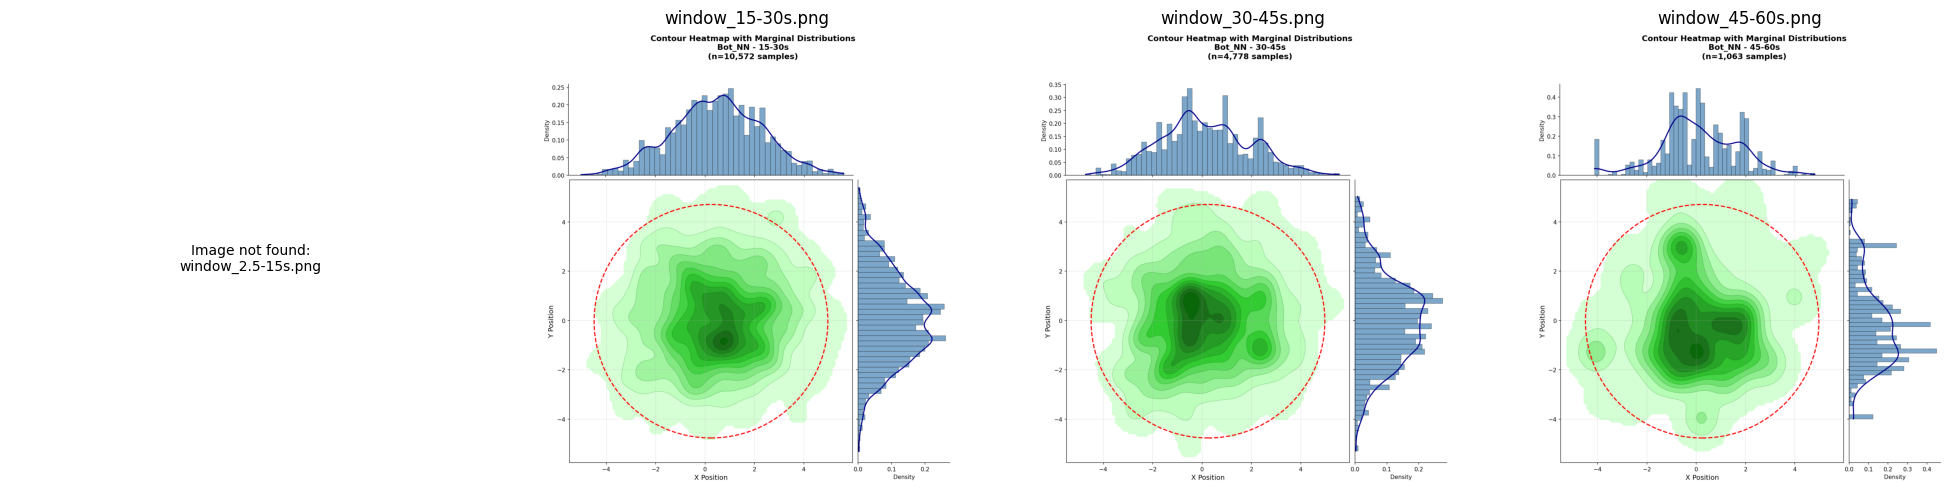


Position Distribution (X & Y Overlayed)


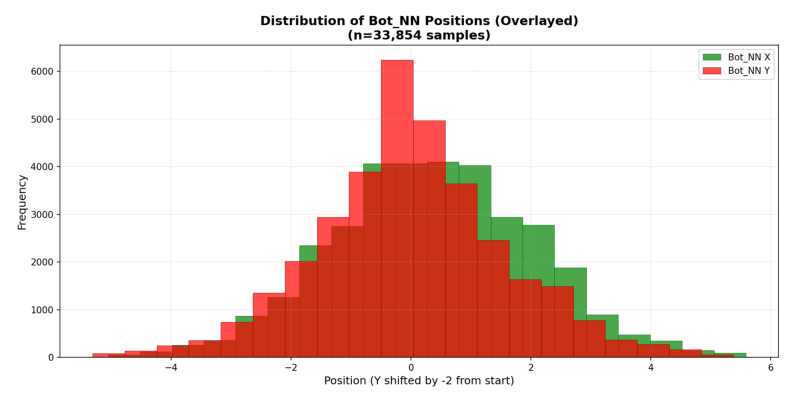


Distance Distribution


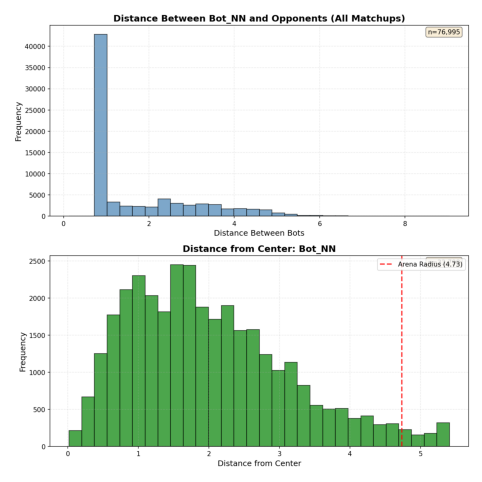


Full Configuration Analysis


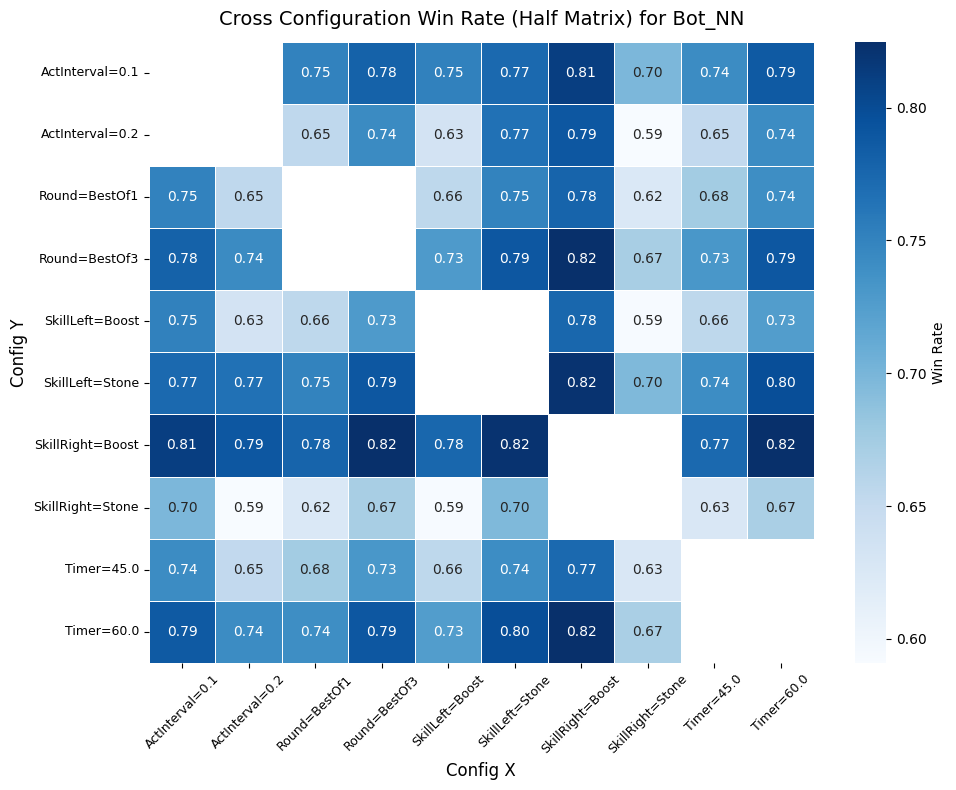


Bot_Primitive (#2)


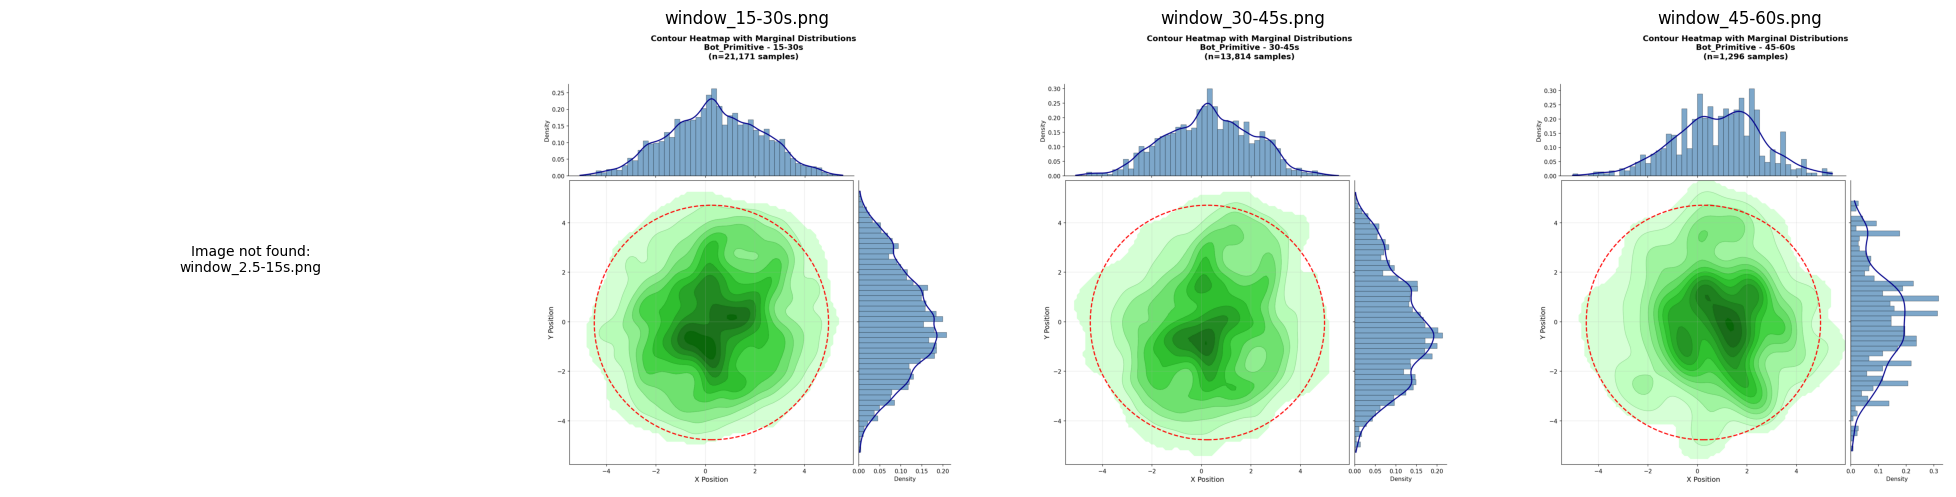


Position Distribution (X & Y Overlayed)


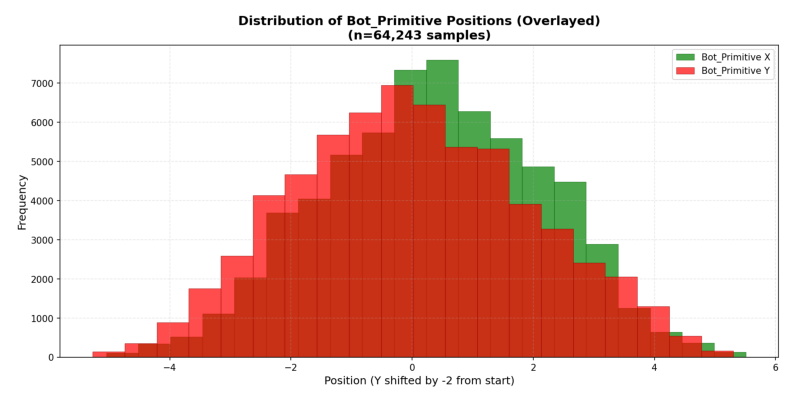


Distance Distribution


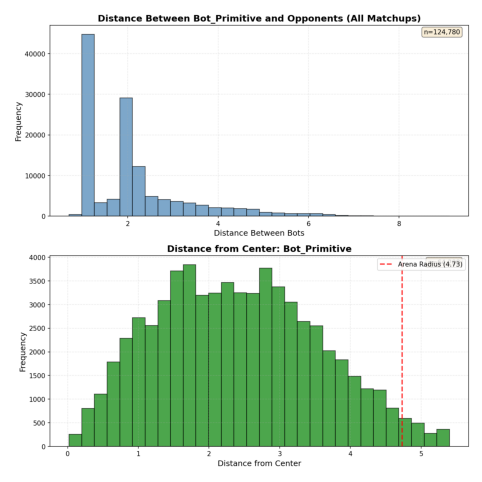


Full Configuration Analysis


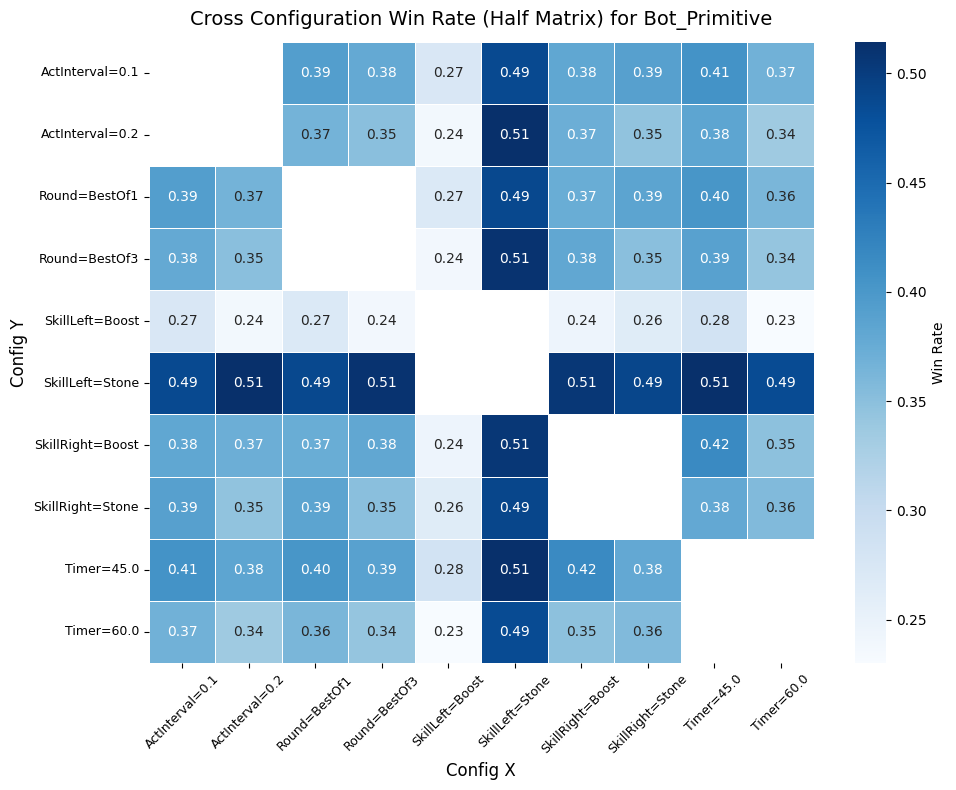


Bot_BT (#3)


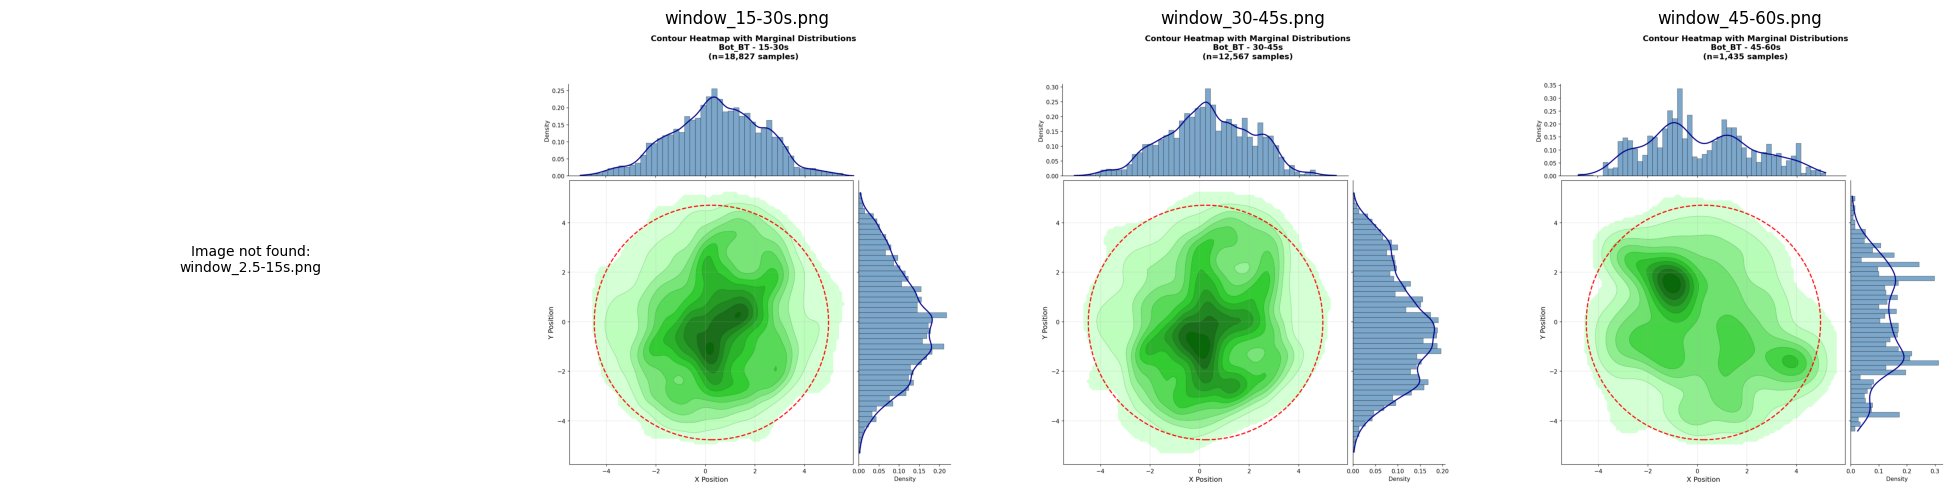


Position Distribution (X & Y Overlayed)


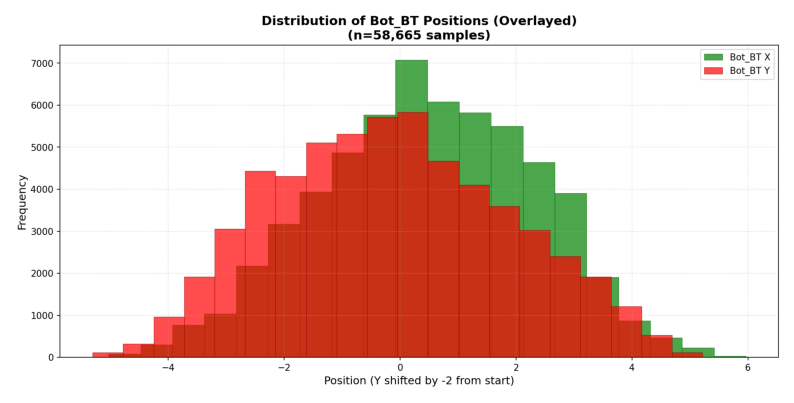


Distance Distribution


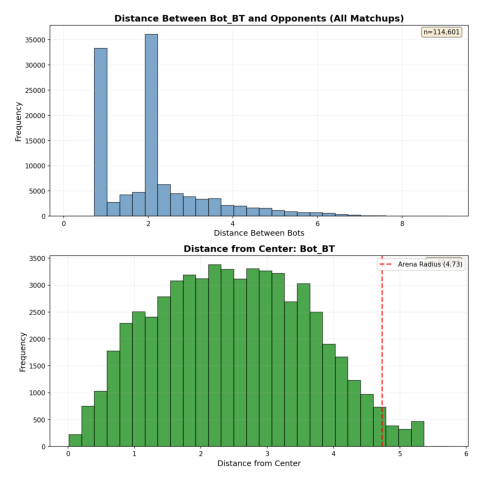


Full Configuration Analysis


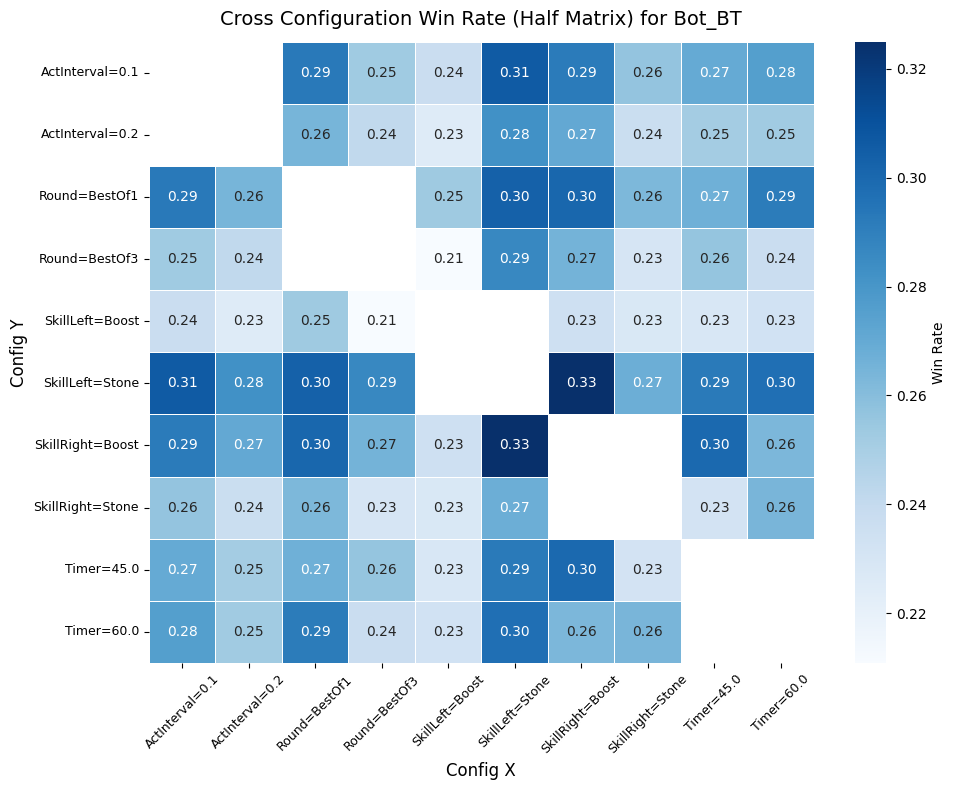


Bot_FSM (#4)


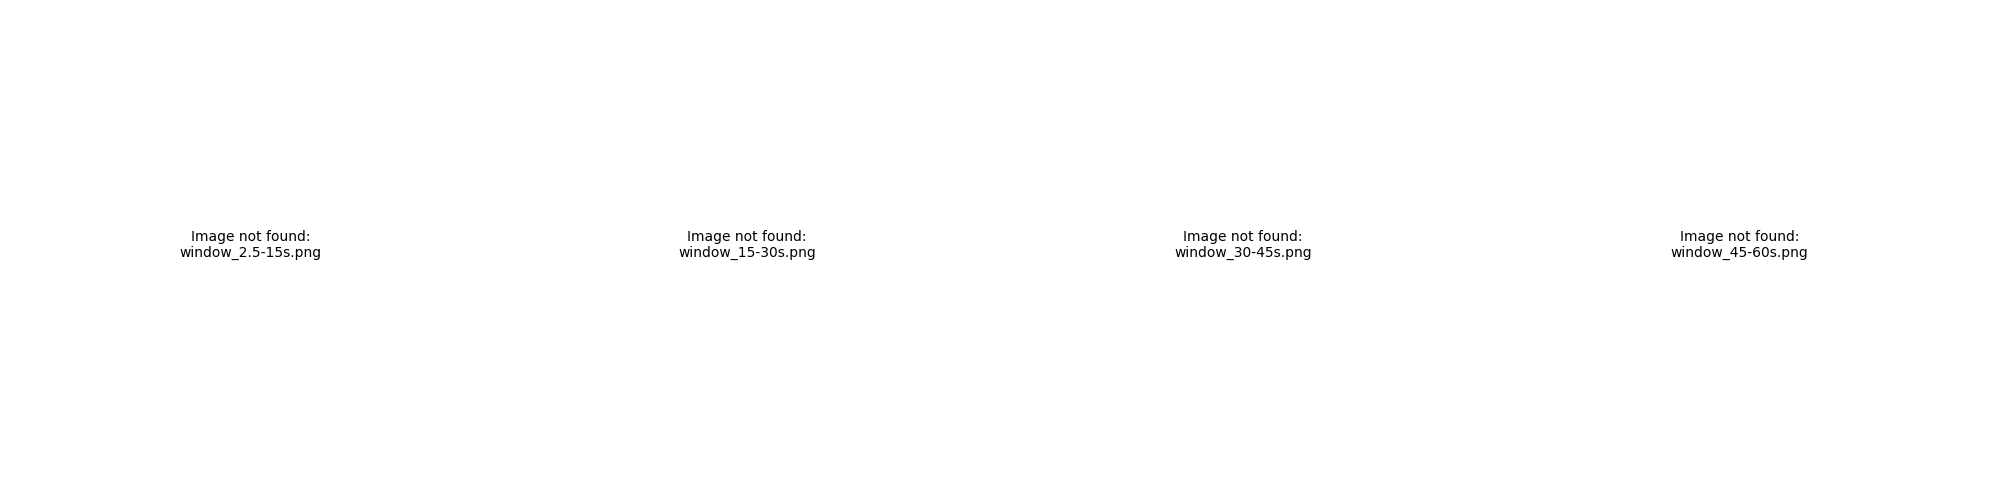


Full Configuration Analysis


ValueError: zero-size array to reduction operation fmin which has no identity

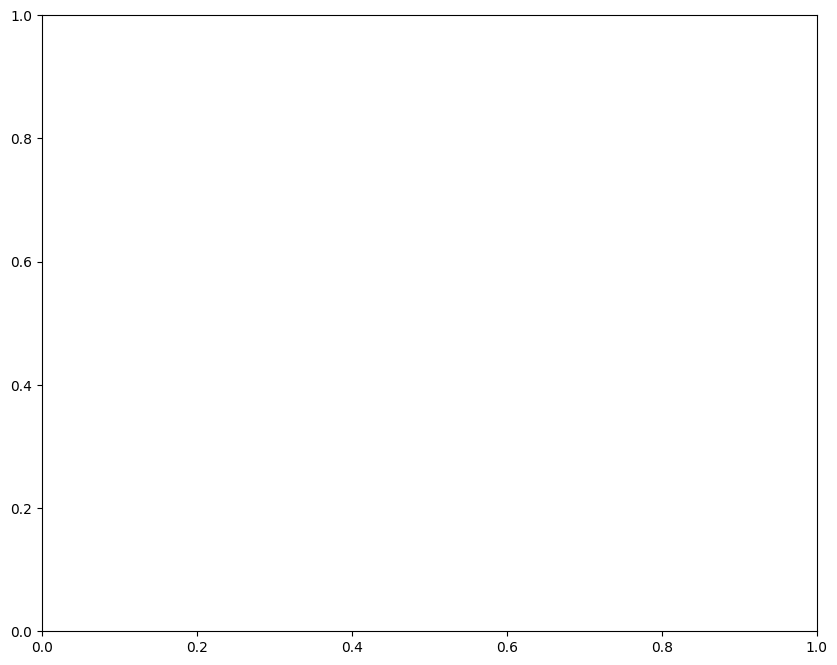

In [4]:
# Check if arena_heatmap directory exists
heatmap_dir = "analysis_output/arena_heatmaps"

if os.path.exists(heatmap_dir):
    # Get all bot directories
    bot_dirs = [d for d in os.listdir(heatmap_dir)
               if os.path.isdir(os.path.join(heatmap_dir, d))]
    
    # Sort bot directories by rank from df_sum
    if "Rank" in df_sum.columns and "Bot" in df_sum.columns:
        rank_map = df_sum.groupby("Bot")["Rank"].first().to_dict()
        bot_dirs = sorted(bot_dirs, key=lambda b: rank_map.get(b, 9999))
    else:
        bot_dirs = sorted(bot_dirs)
    
    if bot_dirs:
        phase_names = ["window_2.5-15s.png", "window_15-30s.png", "window_30-45s.png", "window_45-60s.png"]
        
        # Display heatmaps for each bot
        for bot_name in bot_dirs:
            print(f"\n{'='*60}")
            print(f"{bot_name} (#{bot_dirs.index(bot_name)+1})")
            print(f"{'='*60}")
            bot_dir = os.path.join(heatmap_dir, bot_name)
            
            # Display phase heatmaps
            fig, axes = plt.subplots(1, len(phase_names), figsize=(20, 5))
            for idx, phase_name in enumerate(phase_names):
                image_path = os.path.join(bot_dir, phase_name)
                if os.path.exists(image_path):
                    image = Image.open(image_path)
                    axes[idx].imshow(image)
                    axes[idx].set_title(phase_name)
                    axes[idx].axis('off')
                else:
                    axes[idx].text(0.5, 0.5, f"Image not found:\n{phase_name}",
                                  ha='center', va='center')
                    axes[idx].axis('off')
            plt.tight_layout()
            plt.show()
            
            # Display position distribution
            dist_path = os.path.join(bot_dir, "position_distribution.png")
            if os.path.exists(dist_path):
                print("\nPosition Distribution (X & Y Overlayed)")
                dist_image = Image.open(dist_path)
                plt.figure(figsize=(10, 6))
                plt.imshow(dist_image)
                plt.axis('off')
                plt.show()
            
            # Display distance distribution
            dist_path = os.path.join(bot_dir, "distance_distribution.png")
            if os.path.exists(dist_path):
                print("\nDistance Distribution")
                dist_image = Image.open(dist_path)
                plt.figure(figsize=(10, 6))
                plt.imshow(dist_image)
                plt.axis('off')
                plt.show()

            print("\nFull Configuration Analysis")
            fig = plot_full_cross_heatmap_half(df, bot_name=bot_name, lower_triangle=True)
            plt.show()
    else:
        print("No bot heatmaps found in directory")
        print("Run: `python detailed_analyzer.py all` to generate heatmaps")
else:
    print(f"Heatmap directory not found: {heatmap_dir}")
    print("Run: `python detailed_analyzer.py all` to generate heatmaps for all bots")